<a href="https://colab.research.google.com/github/reshmaamarane/EEG-emotion--AUDIO-BOT/blob/main/PREPROCESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install scipy numpy pandas pywt matplotlib



ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
!pip install PyWavelets==1.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.1 MB/s eta 0:00:00


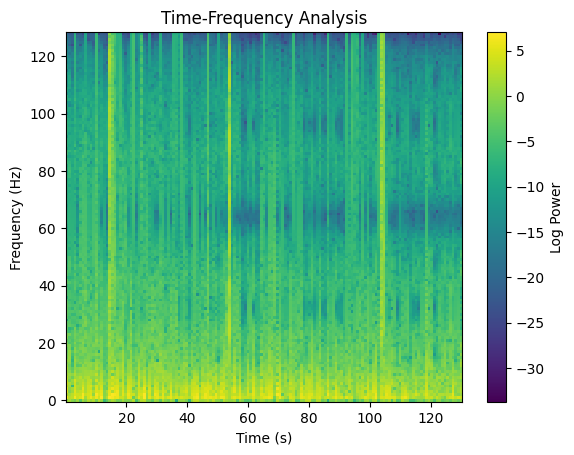

Saved processed data to processed_eeg_data.csv


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    for key in mat.keys():
        if isinstance(mat[key], np.ndarray):  # Assuming EEG data is stored in an array
            eeg_data = mat[key]
            break  # Extract the first ndarray found
    return eeg_data

# **STEP 2: Multi-Scale Principal Component Analysis (MSPCA)**
def apply_mspca(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Thresholding to remove noise
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Apply soft thresholding
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

# **STEP 3: Joint Time-Frequency Analysis (JTFA)**
def apply_jtfa(data, fs=256):  # Assuming 256 Hz sampling rate
    f, t, Sxx = spectrogram(data, fs)

    # Plot the Spectrogram
    plt.pcolormesh(t, f, np.log(Sxx))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Time-Frequency Analysis')
    plt.colorbar(label='Log Power')
    plt.show()

    return f, t, Sxx  # Return spectrogram data if needed

# **STEP 4: Save Processed Data to CSV**
def save_to_csv(data, filename="processed_eeg_data.csv"):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Saved processed data to {filename}")

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518.mat"  # Change this to your actual .mat file path
    eeg_data = load_mat_file(file_path)

    # Apply MSPCA on each EEG channel
    processed_data = np.array([apply_mspca(channel) for channel in eeg_data])

    # Perform Joint Time-Frequency Analysis on the first EEG channel
    apply_jtfa(processed_data[0])

    # Save the processed EEG data
    save_to_csv(processed_data.T)  # Transpose to match CSV format (channels as columns)


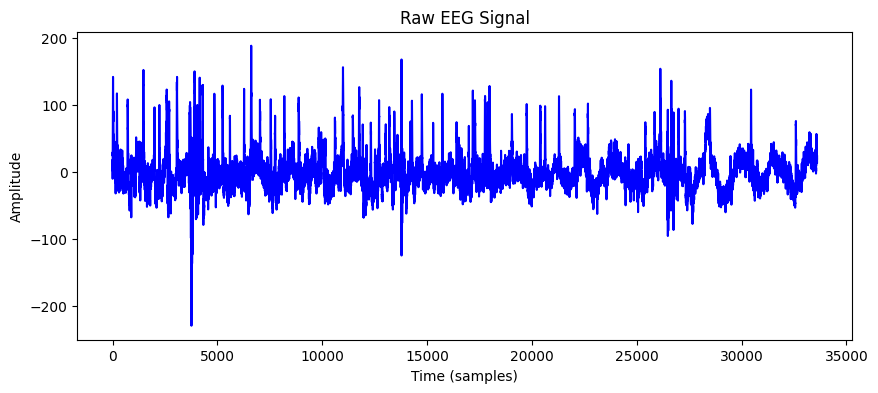

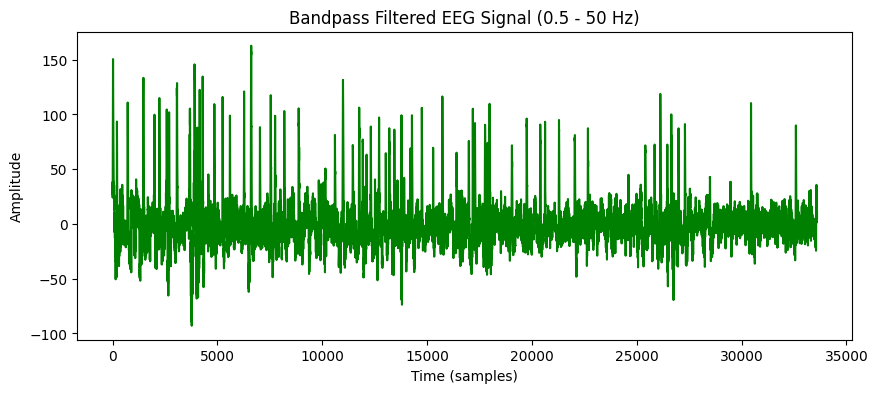

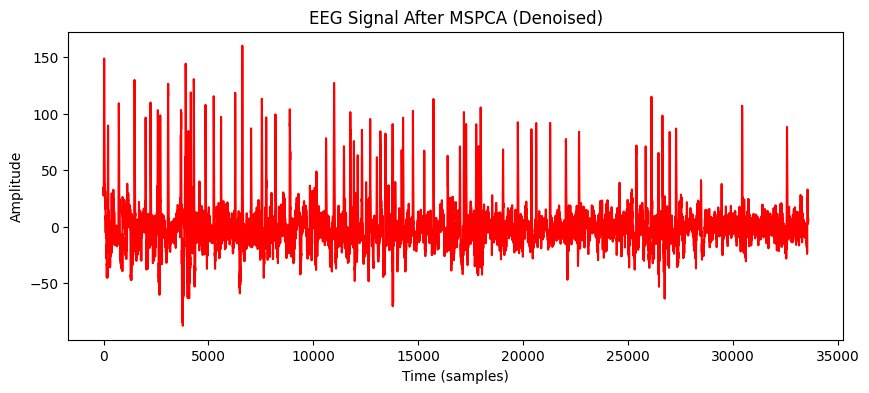

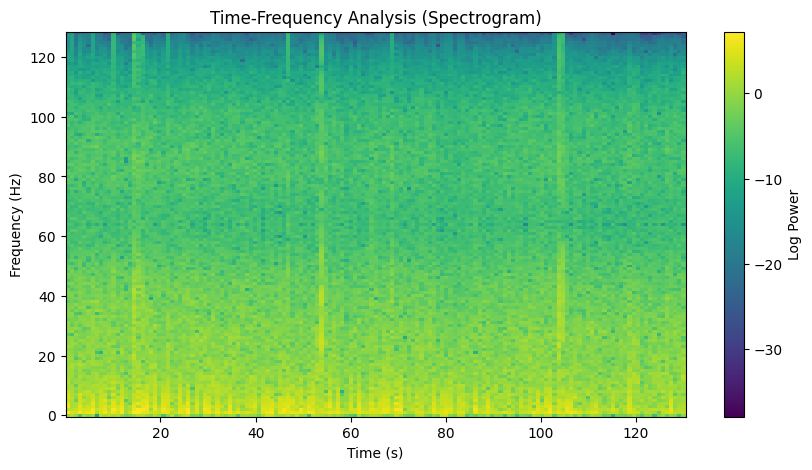

✅ Saved processed data to processed_eeg_data.csv


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    for key in mat.keys():
        if isinstance(mat[key], np.ndarray):  # Extract the first available ndarray
            return mat[key]
    raise ValueError("No valid EEG data found in the .mat file.")

# **STEP 2: Bandpass Filtering (Optional)**
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# **STEP 3: Multi-Scale Principal Component Analysis (MSPCA)**
def apply_mspca(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Thresholding to remove noise
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(data)))

    # Apply soft thresholding
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

    # Reconstruct the signal
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

# **STEP 4: Joint Time-Frequency Analysis (JTFA)**
def apply_jtfa(data, fs=256):
    f, t, Sxx = spectrogram(data, fs)

    # Plot the Spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx), shading='auto')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Time-Frequency Analysis (Spectrogram)')
    plt.colorbar(label='Log Power')
    plt.show()

    return f, t, Sxx

# **STEP 5: Save Processed Data to CSV**
def save_to_csv(data, filename="processed_eeg_data.csv"):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"✅ Saved processed data to {filename}")

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518(raw).mat"  # Change this to your actual .mat file path
    eeg_data = load_mat_file(file_path)

    # Select a single EEG channel (Assume first row is one channel)
    eeg_signal = eeg_data[0, :]

    # **Visualizing Raw EEG Data**
    plt.figure(figsize=(10, 4))
    plt.plot(eeg_signal, color='blue')
    plt.title("Raw EEG Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Apply Bandpass Filter (Optional)**
    filtered_signal = bandpass_filter(eeg_signal)
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_signal, color='green')
    plt.title("Bandpass Filtered EEG Signal (0.5 - 50 Hz)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Apply MSPCA**
    mspca_signal = apply_mspca(filtered_signal)
    plt.figure(figsize=(10, 4))
    plt.plot(mspca_signal, color='red')
    plt.title("EEG Signal After MSPCA (Denoised)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # **Perform Joint Time-Frequency Analysis**
    apply_jtfa(mspca_signal)

    # **Save the Processed EEG Data**
    save_to_csv(mspca_signal)


In [ ]:
import scipy.io

# Load the MAT file
data = scipy.io.loadmat("/content/1_20160518.mat")

# Print all available variable names
print("Variables in .mat file:", data.keys())



Variables in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])


In [ ]:
import scipy.io

# Load the .mat file
file_path = "/content/1_20160518(raw).mat"  # Replace with your file path
data = scipy.io.loadmat(file_path)

# List all variables in the file
print("Variables in the .mat file:", data.keys())






Variables in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])


In [ ]:
print(data.keys())  # Check all variables
cz_eeg1 = data["cz_eeg1"]  # Extract specific EEG channel


dict_keys(['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24'])


In [ ]:
import scipy.io
import numpy as np

def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    print(f"📊 Variables in the .mat file: {list(mat.keys())}")  # Check available variables

    # Extract EEG channels (filtering out metadata like '__header__', '__version__', etc.)
    eeg_channels = [key for key in mat.keys() if key.startswith("cz_eeg")]

    # Load each channel as a NumPy array and ensure it's 1D
    eeg_data_list = [np.squeeze(mat[channel]) for channel in eeg_channels]

    # Check individual channel shapes
    for i, eeg in enumerate(eeg_data_list):
        print(f"🔹 {eeg_channels[i]} Shape: {eeg.shape}")

    # Find the minimum length among all channels
    min_length = min(eeg.shape[0] if eeg.ndim == 1 else eeg.shape[1] for eeg in eeg_data_list)

    # Trim all channels to the same length
    eeg_data = np.array([eeg[:min_length] if eeg.ndim == 1 else eeg[:, :min_length] for eeg in eeg_data_list])

    print(f"✅ Final EEG Data Shape: {eeg_data.shape}")  # (24 channels, min_length samples)
    return eeg_data

# Example usage
file_path = "/content/1_20160518(raw).mat"  # Update with your actual file
eeg_data = load_mat_file(file_path)



📊 Variables in the .mat file: ['__header__', '__version__', '__globals__', 'cz_eeg1', 'cz_eeg2', 'cz_eeg3', 'cz_eeg4', 'cz_eeg5', 'cz_eeg6', 'cz_eeg7', 'cz_eeg8', 'cz_eeg9', 'cz_eeg10', 'cz_eeg11', 'cz_eeg12', 'cz_eeg13', 'cz_eeg14', 'cz_eeg15', 'cz_eeg16', 'cz_eeg17', 'cz_eeg18', 'cz_eeg19', 'cz_eeg20', 'cz_eeg21', 'cz_eeg22', 'cz_eeg23', 'cz_eeg24']
🔹 cz_eeg1 Shape: (62, 33601)
🔹 cz_eeg2 Shape: (62, 19001)
🔹 cz_eeg3 Shape: (62, 39801)
🔹 cz_eeg4 Shape: (62, 26001)
🔹 cz_eeg5 Shape: (62, 17601)
🔹 cz_eeg6 Shape: (62, 32401)
🔹 cz_eeg7 Shape: (62, 30601)
🔹 cz_eeg8 Shape: (62, 41801)
🔹 cz_eeg9 Shape: (62, 29001)
🔹 cz_eeg10 Shape: (62, 33801)
🔹 cz_eeg11 Shape: (62, 10001)
🔹 cz_eeg12 Shape: (62, 22001)
🔹 cz_eeg13 Shape: (62, 43401)
🔹 cz_eeg14 Shape: (62, 33801)
🔹 cz_eeg15 Shape: (62, 51801)
🔹 cz_eeg16 Shape: (62, 28201)
🔹 cz_eeg17 Shape: (62, 13601)
🔹 cz_eeg18 Shape: (62, 35801)
🔹 cz_eeg19 Shape: (62, 28001)
🔹 cz_eeg20 Shape: (62, 9601)
🔹 cz_eeg21 Shape: (62, 22401)
🔹 cz_eeg22 Shape: (62, 224

In [6]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)

    # Extract all EEG channel variables
    eeg_data_list = [mat[key] for key in mat.keys() if key.startswith("cz_eeg")]

    # Find the minimum length to trim all channels
    min_length = min(eeg.shape[1] for eeg in eeg_data_list)

    # Trim all channels to the same length
    eeg_data = np.array([eeg[:, :min_length] for eeg in eeg_data_list])  # Shape: (24, 62, min_length)

    print(f"✅ Final EEG Data Shape: {eeg_data.shape}")  # Expected: (24, 62, min_length)
    return eeg_data

# **STEP 2: Define Channel Layout**
def define_channels(eeg_data):
    num_channels, num_components, num_samples = eeg_data.shape
    print(f"📊 EEG Data: {num_channels} Channels, {num_components} Components, {num_samples} Samples")
    return eeg_data

# **STEP 3: Bandpass Filtering (0.5 - 50 Hz)**
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=200, order=4):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)  # Apply along the time axis

# **STEP 4: Re-referencing (Common Average Reference - CAR)**
def re_reference(data):
    avg_ref = np.mean(data, axis=0)  # Compute average across channels
    return data - avg_ref  # Subtract common reference

# **STEP 5: Artifact Removal Using MSPCA**
def apply_mspca(data, wavelet='db4', level=4):
    denoised_data = np.zeros_like(data)

    for trial in range(data.shape[0]):  # Loop over trials/sessions
        for channel in range(data.shape[1]):  # Loop over EEG channels
            coeffs = pywt.wavedec(data[trial, channel, :], wavelet, level=level)
            sigma = np.median(np.abs(coeffs[-1])) / 0.6745
            threshold = sigma * np.sqrt(2 * np.log(len(data[trial, channel, :])))
            denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

            # Perform reconstruction and trim excess samples
            reconstructed = pywt.waverec(denoised_coeffs, wavelet)
            denoised_data[trial, channel, :] = reconstructed[:data.shape[2]]  # Trim to match original length

    return denoised_data


# **STEP 6: Thresholding (Remove High Amplitude Artifacts)**
def threshold_rejection(data, threshold=100):  # Adjust threshold as needed
    mask = np.abs(data) < threshold
    return np.where(mask, data, np.nan)  # Replace artifacts with NaN

# **STEP 7: Epoching (Segmenting into Fixed Windows)**
def epoch_data(data, fs=200, epoch_length=2):  # 2s epochs
    samples_per_epoch = int(fs * epoch_length)
    num_epochs = data.shape[2] // samples_per_epoch
    return np.array(np.split(data[:, :, :num_epochs * samples_per_epoch], num_epochs, axis=2))

# **STEP 8: Baseline Correction (Subtract Mean)**
def baseline_correction(epochs):
    return epochs - np.mean(epochs, axis=2, keepdims=True)

# **STEP 9: Save Processed EEG Data to CSV**
def save_to_csv(data, filename="processed_eeg_data.csv"):
    reshaped_data = data.reshape(data.shape[0], -1)  # Flatten epochs
    df = pd.DataFrame(reshaped_data.T)  # Transpose for CSV format
    df.to_csv(filename, index=False)
    print(f"✅ Saved processed data to {filename}")

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518(raw).mat"  # Update with your actual file path

    eeg_data = load_mat_file(file_path)
    eeg_data = define_channels(eeg_data)

    filtered_data = bandpass_filter(eeg_data)
    re_referenced_data = re_reference(filtered_data)
    denoised_data = apply_mspca(re_referenced_data)
    thresholded_data = threshold_rejection(denoised_data)
    epochs = epoch_data(thresholded_data)
    corrected_epochs = baseline_correction(epochs)

    save_to_csv(corrected_epochs)


✅ Final EEG Data Shape: (24, 62, 9601)
📊 EEG Data: 24 Channels, 62 Components, 9601 Samples
✅ Saved processed data to processed_eeg_data.csv


✅ Final EEG Data Shape: (24, 62, 9601)
📊 EEG Data: 24 Channels, 62 Components, 9601 Samples


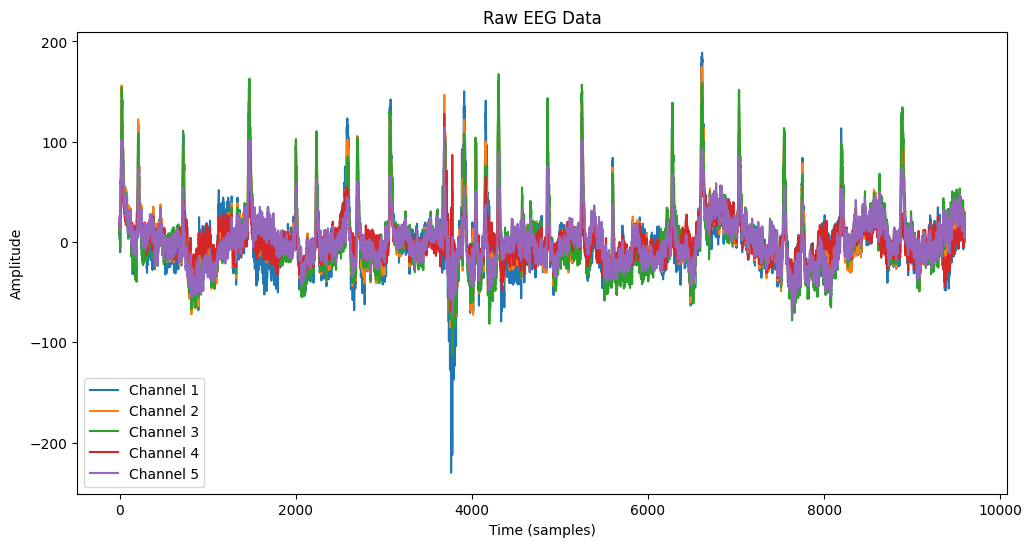

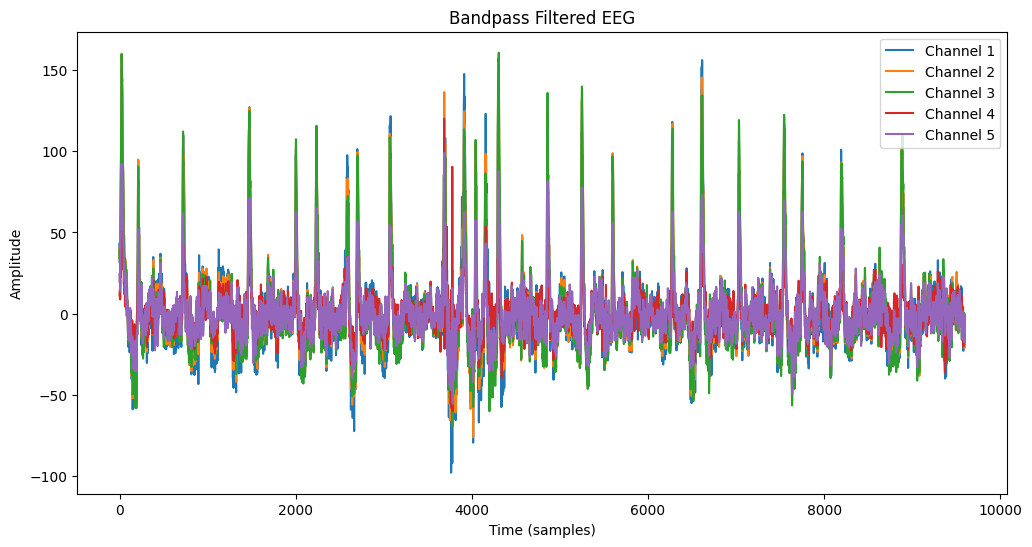

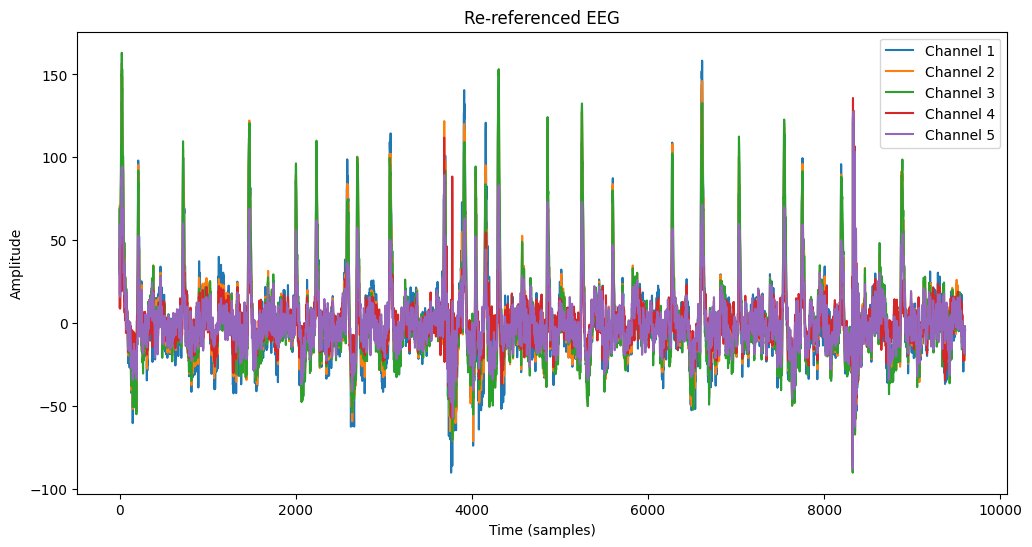

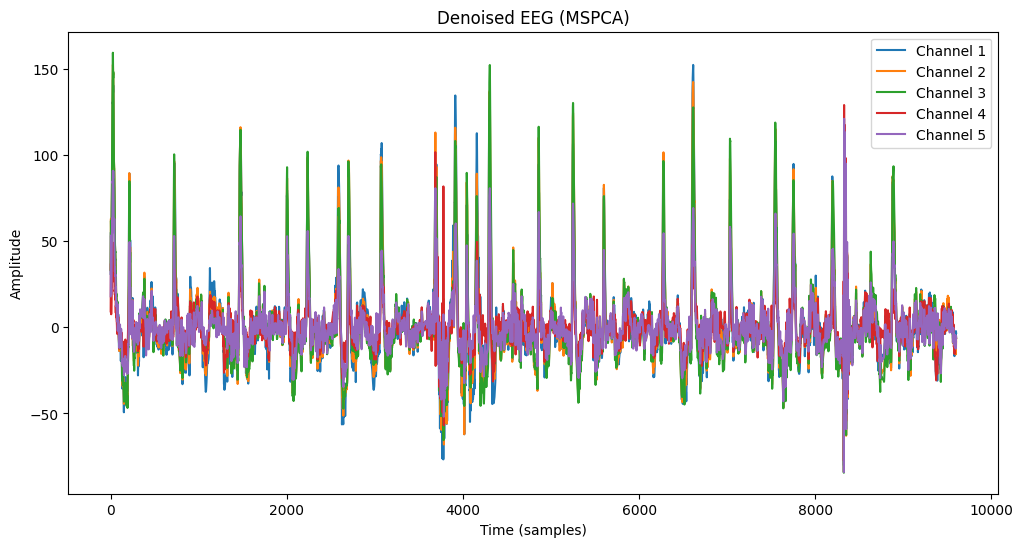

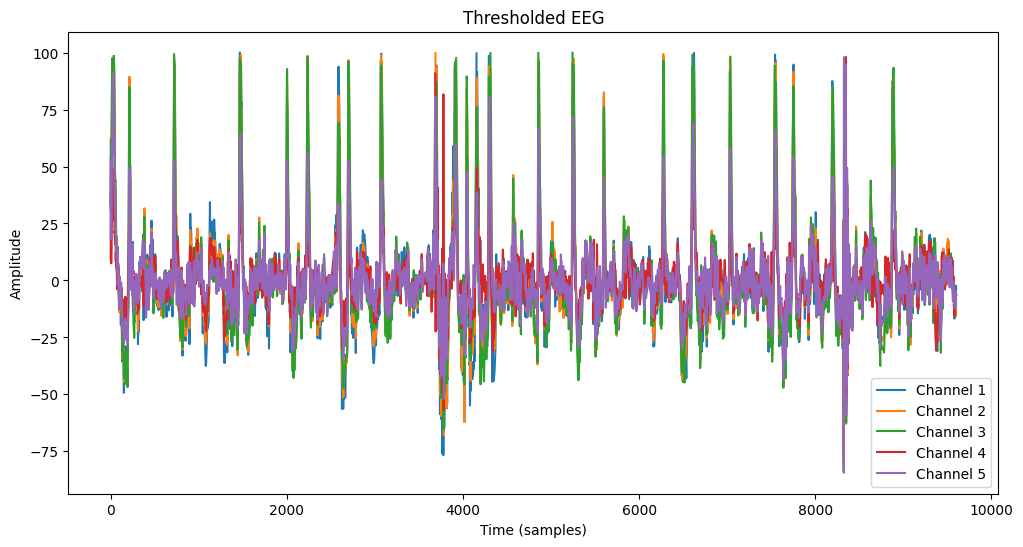

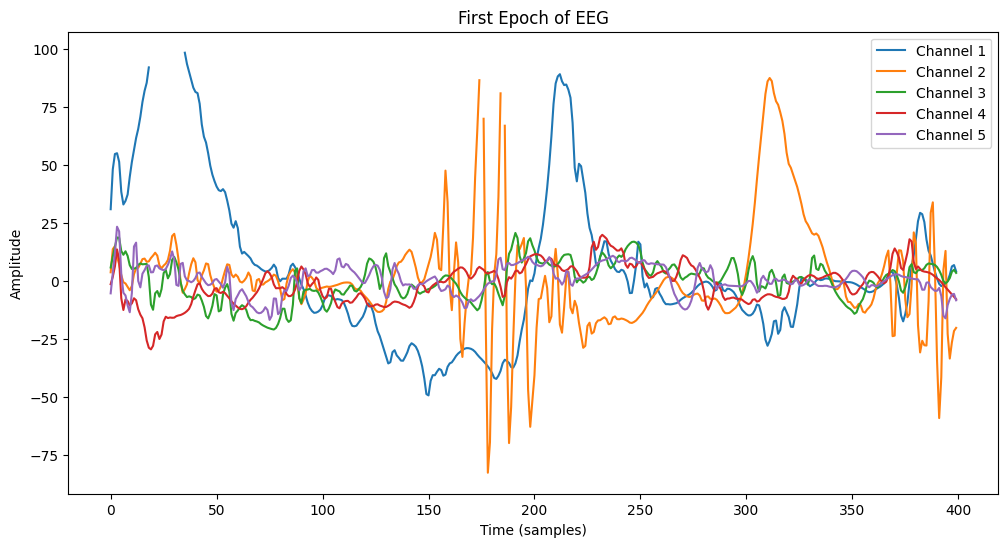

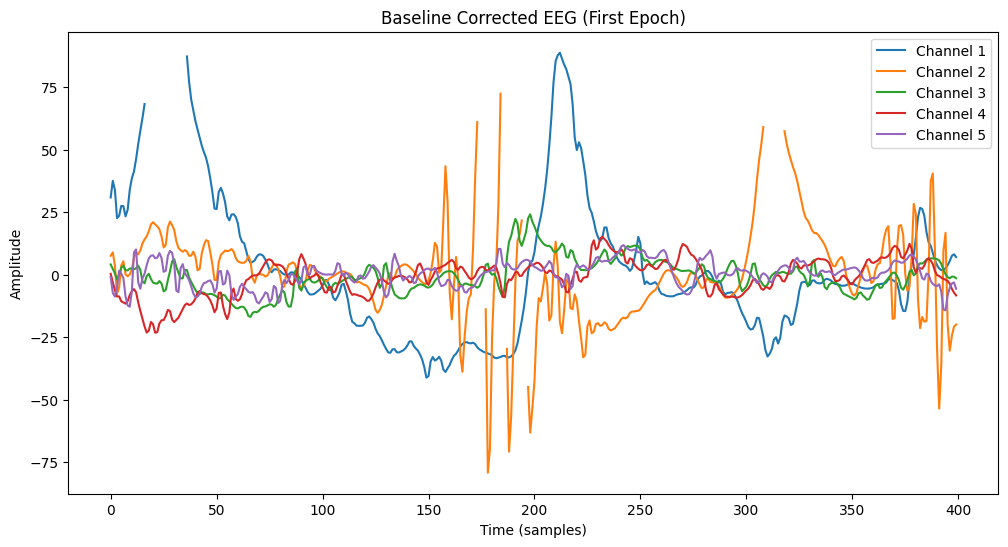

In [7]:
import numpy as np
import scipy.io
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# **STEP 1: Load EEG Data from .mat File**
def load_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    eeg_data_list = [mat[key] for key in mat.keys() if key.startswith("cz_eeg")]
    min_length = min(eeg.shape[1] for eeg in eeg_data_list)
    eeg_data = np.array([eeg[:, :min_length] for eeg in eeg_data_list])  # Shape: (24, 62, min_length)

    print(f"✅ Final EEG Data Shape: {eeg_data.shape}")  # Expected: (24, 62, min_length)
    return eeg_data

# **STEP 2: Define Channel Layout**
def define_channels(eeg_data):
    num_channels, num_components, num_samples = eeg_data.shape
    print(f"📊 EEG Data: {num_channels} Channels, {num_components} Components, {num_samples} Samples")
    return eeg_data

# **STEP 3: Bandpass Filtering (0.5 - 50 Hz)**
def bandpass_filter(data, lowcut=0.5, highcut=50, fs=200, order=4):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=-1)

    visualize_data(filtered_data, "Bandpass Filtered EEG")
    return filtered_data

# **STEP 4: Re-referencing (Common Average Reference - CAR)**
def re_reference(data):
    avg_ref = np.mean(data, axis=0)
    re_referenced_data = data - avg_ref

    visualize_data(re_referenced_data, "Re-referenced EEG")
    return re_referenced_data

# **STEP 5: Artifact Removal Using MSPCA**
def apply_mspca(data, wavelet='db4', level=4):
    denoised_data = np.zeros_like(data)

    for trial in range(data.shape[0]):
        for channel in range(data.shape[1]):
            coeffs = pywt.wavedec(data[trial, channel, :], wavelet, level=level)
            sigma = np.median(np.abs(coeffs[-1])) / 0.6745
            threshold = sigma * np.sqrt(2 * np.log(len(data[trial, channel, :])))
            denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            reconstructed = pywt.waverec(denoised_coeffs, wavelet)
            denoised_data[trial, channel, :] = reconstructed[:data.shape[2]]

    visualize_data(denoised_data, "Denoised EEG (MSPCA)")
    return denoised_data

# **STEP 6: Thresholding (Remove High Amplitude Artifacts)**
def threshold_rejection(data, threshold=100):
    mask = np.abs(data) < threshold
    thresholded_data = np.where(mask, data, np.nan)

    visualize_data(thresholded_data, "Thresholded EEG")
    return thresholded_data

# **STEP 7: Epoching (Segmenting into Fixed Windows)**
def epoch_data(data, fs=200, epoch_length=2):
    samples_per_epoch = int(fs * epoch_length)
    num_epochs = data.shape[2] // samples_per_epoch
    epochs = np.array(np.split(data[:, :, :num_epochs * samples_per_epoch], num_epochs, axis=2))

    visualize_data(epochs[:, :, 0, :], "First Epoch of EEG")  # Show first epoch
    return epochs

# **STEP 8: Baseline Correction (Subtract Mean)**
def baseline_correction(epochs):
    corrected_epochs = epochs - np.mean(epochs, axis=2, keepdims=True)

    visualize_data(corrected_epochs[:, :, 0, :], "Baseline Corrected EEG (First Epoch)")
    return corrected_epochs

# **STEP 9: Save Processed EEG Data to CSV**
# def save_to_csv(data, filename="processed_eeg_data.csv"):
#     reshaped_data = data.reshape(data.shape[0], -1)
#     df = pd.DataFrame(reshaped_data.T)
#     df.to_csv(filename, index=False)
#     print(f"✅ Saved processed data to {filename}")

# **Visualization Function**
def visualize_data(data, title, num_channels=5):
    plt.figure(figsize=(12, 6))

    # Select a few channels to plot
    for i in range(min(num_channels, data.shape[1])):
        plt.plot(data[0, i, :], label=f'Channel {i+1}')

    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# **MAIN FUNCTION**
if __name__ == "__main__":
    file_path = "/content/1_20160518(raw).mat"  # Update with your actual file path

    eeg_data = load_mat_file(file_path)
    eeg_data = define_channels(eeg_data)

    visualize_data(eeg_data, "Raw EEG Data")  # Visualizing raw data

    filtered_data = bandpass_filter(eeg_data)
    re_referenced_data = re_reference(filtered_data)
    denoised_data = apply_mspca(re_referenced_data)
    thresholded_data = threshold_rejection(denoised_data)
    epochs = epoch_data(thresholded_data)
    corrected_epochs = baseline_correction(epochs)

    # save_to_csv(corrected_epochs)
